# Variational Autoencoder (VAE)

An autoencoder whose training is regularised to avoid overfitting and ensure that the latent space has good properties that enable generative process.

In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random

## Hyperparameters

In [2]:
batch_size = 128
learning_rate = 0.001
num_epochs = 10

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Dataset

In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                    transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=1
)

## Model

In [5]:
from utils import VAE

imgChannels = 1
featureDim = 32 * 20 * 20
zDim = 4

model = VAE(imgChannels, featureDim, zDim).to(device)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr = learning_rate
)


### Training

Denoising Autoencoder takes a noisy image as input and the target for the output layer is the original input without noise.

In [6]:
def add_noise(inputs, noise_factor = 0.3):
     noisy = inputs + torch.randn_like(inputs) * noise_factor
     noisy = torch.clip(noisy,0.,1.)
     return noisy

In [7]:
import torchvision.transforms as T
from PIL import Image
import transformations as trans

img_list = next(iter(train_loader))
img_list = img_list[0][0:2]
# img = img.permute(1, 2, 0)

# for img in img_list:
#     print(img.shape)
#     transform = T.ToPILImage()
#     img = transform(img)
#     img = np.array(img)
#     # img = cv2.resize(img,(800,800))
#     plt.subplot(121)
#     plt.imshow( img )
    
#     noisy = trans.add_rain(img, rain_type = "heavy")
#     plt.subplot(122)
#     plt.imshow( noisy )
#     plt.show()




In [8]:
import transformations as trans
import torchvision.transforms as T
from PIL import Image

def add_perturbation(inputs):

    # print(inputs.shape, inputs.type())
    transform = T.ToPILImage()
    perturbed_imgs = []
    
    # process batch
    for img in inputs:
        img = transform(img)
        img = np.array(img)
        perturbed_img = trans.add_rain(img, rain_type = "heavy")
        perturbed_imgs.append(perturbed_img)

    perturbed_imgs = np.array(perturbed_imgs) 
    perturbed_imgs = torch.from_numpy(perturbed_imgs).permute(0, 3, 2, 1)
    perturbed_imgs = perturbed_imgs.to(torch.float)
    # print(perturbed_imgs.shape, perturbed_imgs.type())
    return perturbed_imgs


In [13]:
for epoch in range(num_epochs):
    train_loss = 0.0
    for data, labels in train_loader:
        
        data = add_noise(data)

        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()

        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logVar = model(data)

        # For Generating is better KL
        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        # kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        # loss = F.binary_cross_entropy(out, data, size_average=False) + kl_divergence

        # For Denoising is better MSE
        loss = F.mse_loss(out, data)

        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    valid_loss = 0.0
    model.eval() 
    for data, labels in test_loader:

        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
         
        out = model(data)
        loss = F.mse_loss(out, data)
        valid_loss += loss.item()

    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(test_loader)}')

C:\Users\ivanr\AppData\Local\Temp\ipykernel_11448\2112589728.py:36: UserWarning: Using a target size (torch.Size([1, 1, 28, 28])) that is different to the input size (torch.Size([96, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, data)


Epoch 1 		 Training Loss: 0.09862823582597888 		 Validation Loss: 0.08802150701098144
Epoch 2 		 Training Loss: 0.05816045571873183 		 Validation Loss: 0.09523405119478702


## Visualization and Evaluation

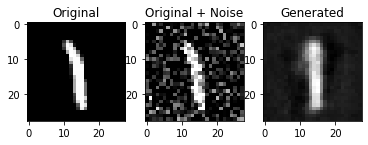

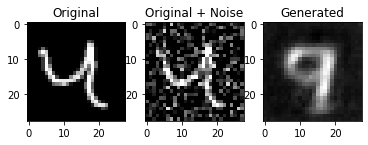

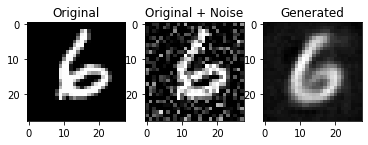

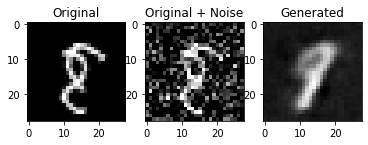

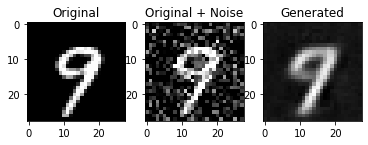

In [14]:
model.eval()
imgs_to_show = 5

with torch.no_grad():
    for data in random.sample(list(test_loader), imgs_to_show):
        
        # Original
        imgs, _ = data
        imgs = imgs.to(device)
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(131)
        plt.title("Original")
        plt.imshow(np.squeeze(img), cmap='gray')

        # Original + Noise
        imgs, _ = data
        imgs = add_noise(imgs, 0.3)
        imgs = imgs.to(device)
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(132)
        plt.title("Original + Noise")
        plt.imshow(np.squeeze(img), cmap='gray')

        # Generated
        out, mu, logVAR = model(imgs)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(133)
        plt.imshow(np.squeeze(outimg), cmap='gray')
        plt.title("Generated")
        plt.show()